# Setup

<table align="left">
  <td>
      <a href="https://colab.research.google.com/github/lorenzobalzani/Credit-cards-default-ML/blob/master/creditCardsDefault.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
  </td>
</table>

In [2]:
!pip install wget
!pip install graphviz
!pip install thundersvm
import wget
import urllib
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import keras
from keras.models import Sequential
from sklearn.dummy import DummyClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras.initializers import glorot_uniform, Orthogonal, RandomNormal
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
from xgboost import XGBClassifier
import tensorflow as tf
from keras.callbacks import Callback,ModelCheckpoint
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Constants
randSeed = 42
nSplitsGS = 3
confidenceLevel = 0.95

## Utility 
models = {}
skf = StratifiedKFold(n_splits=nSplitsGS, shuffle=True, random_state=randSeed)

Processing /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f/wget-3.2-cp37-none-any.whl
     |████████████████████████████████| 512kB 11.0MB/s 


In [3]:
url = 'https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py' 
filename = 'cf_matrix.py'

if not os.path.isfile(filename):
    wget.download(url)
    
sys.path.append(os.path.abspath("./cf_matrix.py"))
from cf_matrix import make_confusion_matrix

In [4]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

--2021-06-25 15:22:30--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.16.29
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.16.29|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2021-06-25 15:22:30--  https://developer.nvidia.com/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?cCTPIaj0PUNEdygzF-dhsEsQ1VBDTaUqrZkaDOe5fPdcnIB7vx-2PxrZM6OMDL6KB9qZ1vA5-Zv89N2WHiQ7jwOoE_1Xqdl

# Descrizione del problema
Il dataset scelto ha come scopo la classificazione binaria (solvente o non solvente) della carta di credito da parte dei clienti di istituti finanziari a Taiwan.

# Data exploration

## Data upload

Carico il dataset e imposto come indice la prima colonna (ID) e come header la prima riga.

In [5]:
dataset = pd.read_csv('https://raw.githubusercontent.com/lorenzobalzani/Credit-cards-default-ML/master/dataset.csv', sep=";", header=0, index_col=0)
dataset = dataset.rename(columns={'default payment next month' : 'default pay'})

In [6]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default pay
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
dataset.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default pay
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   LIMIT_BAL    30000 non-null  int64
 1   SEX          30000 non-null  int64
 2   EDUCATION    30000 non-null  int64
 3   MARRIAGE     30000 non-null  int64
 4   AGE          30000 non-null  int64
 5   PAY_1        30000 non-null  int64
 6   PAY_2        30000 non-null  int64
 7   PAY_3        30000 non-null  int64
 8   PAY_4        30000 non-null  int64
 9   PAY_5        30000 non-null  int64
 10  PAY_6        30000 non-null  int64
 11  BILL_AMT1    30000 non-null  int64
 12  BILL_AMT2    30000 non-null  int64
 13  BILL_AMT3    30000 non-null  int64
 14  BILL_AMT4    30000 non-null  int64
 15  BILL_AMT5    30000 non-null  int64
 16  BILL_AMT6    30000 non-null  int64
 17  PAY_AMT1     30000 non-null  int64
 18  PAY_AMT2     30000 non-null  int64
 19  PAY_AMT3     30000 non-null  int64
 20  PAY_AM

## Rilevazione di valori nulli

Si rilevano, se presenti, valori nulli nel dataset.  
In questo dataset, non sono presenti valori nulli, quindi non risulta necessario trattarli.

In [9]:
dataset.isna().sum()

LIMIT_BAL      0
SEX            0
EDUCATION      0
MARRIAGE       0
AGE            0
PAY_1          0
PAY_2          0
PAY_3          0
PAY_4          0
PAY_5          0
PAY_6          0
BILL_AMT1      0
BILL_AMT2      0
BILL_AMT3      0
BILL_AMT4      0
BILL_AMT5      0
BILL_AMT6      0
PAY_AMT1       0
PAY_AMT2       0
PAY_AMT3       0
PAY_AMT4       0
PAY_AMT5       0
PAY_AMT6       0
default pay    0
dtype: int64

## Comprensione delle features

Nello specifico, le **features** disponibili (come si può osservare nella cella soprastante) sono:

1. LIMIT_BAL | Credito totale (indivudale+familiare) disponibile  | int (New Taiwan dollar)
2. SEX | 1: male, 2: female |
3. EDUCATION | 1: graduate school, 2: university, 3: high school, 4: others | 
4. MARRIAGE | 1: married, 2: single, 3: others | 
5. AGE | age | int (years)
6. PAY_1 | Repayment status in September, 2005 | view description below
7. PAY_2 | Repayment status in August, 2005 | view description below
8. PAY_3 | Repayment status in July, 2005 | view description below
9. PAY_4 | Repayment status in June, 2005 | view description below
10. PAY_5 | Repayment status in May, 2005 | view description below
11. PAY_6 | Repayment status in April, 2005 | view description below
12. BILL_AMT1 | Amout of bill statement in September, 2005 | int (New Taiwan dollar)
13. BILL_AMT2 | Amout of bill statement in August, 2005 | int (New Taiwan dollar)
14. BILL_AMT3 | Amout of bill statement in July, 2005 | int (New Taiwan dollar)
15. BILL_AMT4 | Amout of bill statement in June, 2005 | int (New Taiwan dollar)
16. BILL_AMT5 | Amout of bill statement in May, 2005 | int (New Taiwan dollar)
17. BILL_AMT6 | Amout of bill statement in April, 2005 | int (New Taiwan dollar)
18. PAY_AMT1 | Amount paid in September, 2005 | int (New Taiwan dollar)
19. PAY_AMT2 | Amount paid in August, 2005 | int (New Taiwan dollar)
20. PAY_AMT3 | Amount paid in July, 2005 | int (New Taiwan dollar)
21. PAY_AMT4 | Amount paid in June, 2005 | int (New Taiwan dollar)
22. PAY_AMT5 | Amount paid in May, 2005 | int (New Taiwan dollar)
23. PAY_AMT6 | Amount paid in April, 2005 | int (New Taiwan dollar)
24. Default payment next month | Target Variable | Yes: 1, No: 0 | binary

Le variabili da PAY0 a PAY6 sono categoriche (saranno trasformate in seguito). Sono codificate nel seguente modo:
-1: pagamento effettuato in tempo;
2: pagamento ritardato di 2 mesi;
...
8: pagamento ritardato di 8 mesi;
9: pagamento ritardato di 9 mesi o più.

Le features esaminate sono sia categoriche che continue.
Quelle categoriche sono: `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_1`, `PAY_2`, `PAY_3`, `PAY_4`, `PAY_5` and `PAY_6`.
Quelle continue sono: `LIMIT_BAL`, `AGE`, `BILL_AMT1`, `BILL_AMT2`, `BILL_AMT3`, `BILL_AMT4`, `BILL_AMT5`, `BILL_AMT6`, `PAY_AMT1`, `PAY_AMT2`, `PAY_AMT3`, `PAY_AMT4`, `PAY_AMT5` e `PAY_AMT6`.

## Distribuzioni

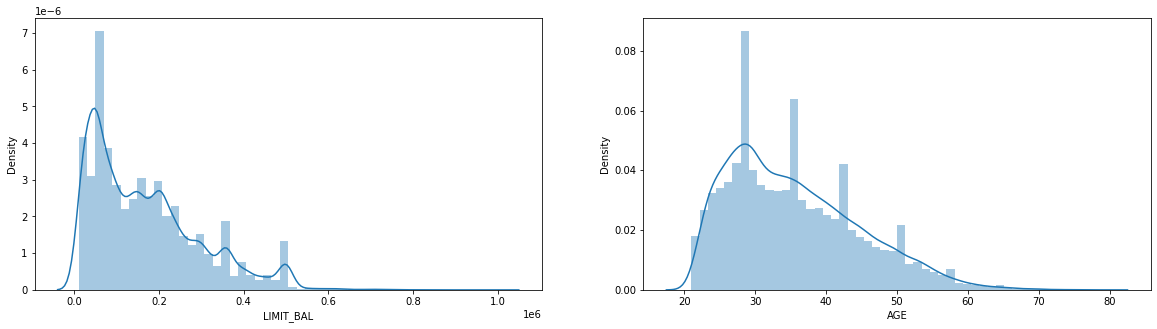

In [10]:
plt.subplots(figsize=(20,5))
plt.subplot(121)
sns.distplot(dataset.LIMIT_BAL)

plt.subplot(122)
sns.distplot(dataset.AGE)

plt.show()

Dai grafici si evince che le variabili continue consistono nella limitazione del credito e l'età dei clienti. La maggior parte dei clienti ha credito nella fascia tra zero e 200k. 
Inoltre, per quanto concerne l'età, abbiamo la maggior parte dei clienti nella fascia 20-40. Di seguito osserveremo come le distribuzioni continue impattano sulla variabile target `default pay.

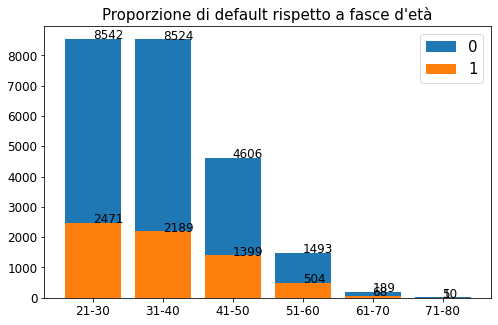

In [11]:
bins = [20,30,40,50,60,70,80]
names = ['21-30','31-40','41-50','51-60','61-70','71-80']
dataset['AGE_BIN'] = pd.cut(x=dataset.AGE, bins=bins, labels=names, right=True)

age_cnt = dataset.AGE_BIN.value_counts()
age_0 = (dataset.AGE_BIN[dataset['default pay'] == 0].value_counts())
age_1 = (dataset.AGE_BIN[dataset['default pay'] == 1].value_counts())

plt.subplots(figsize=(8,5))
plt.bar(age_0.index, age_0.values, label='0')
plt.bar(age_1.index, age_1.values, label='1')
for x,y in zip(names,age_0):
    plt.text(x,y,y,fontsize=12)
for x,y in zip(names,age_1):
    plt.text(x,y,y,fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Proporzione di default rispetto a fasce d'età", fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.show()
dataset.drop('AGE_BIN', axis=1, inplace=True)

La maggior parte dei clienti appartiene alla fascia tra 21 e 30 anni. Si nota come con l'aumentare dell'età del cliente decresce la probabilità di default nel mese successivo. Possiamo concludere che si tratti di una feature importante per la predizione.

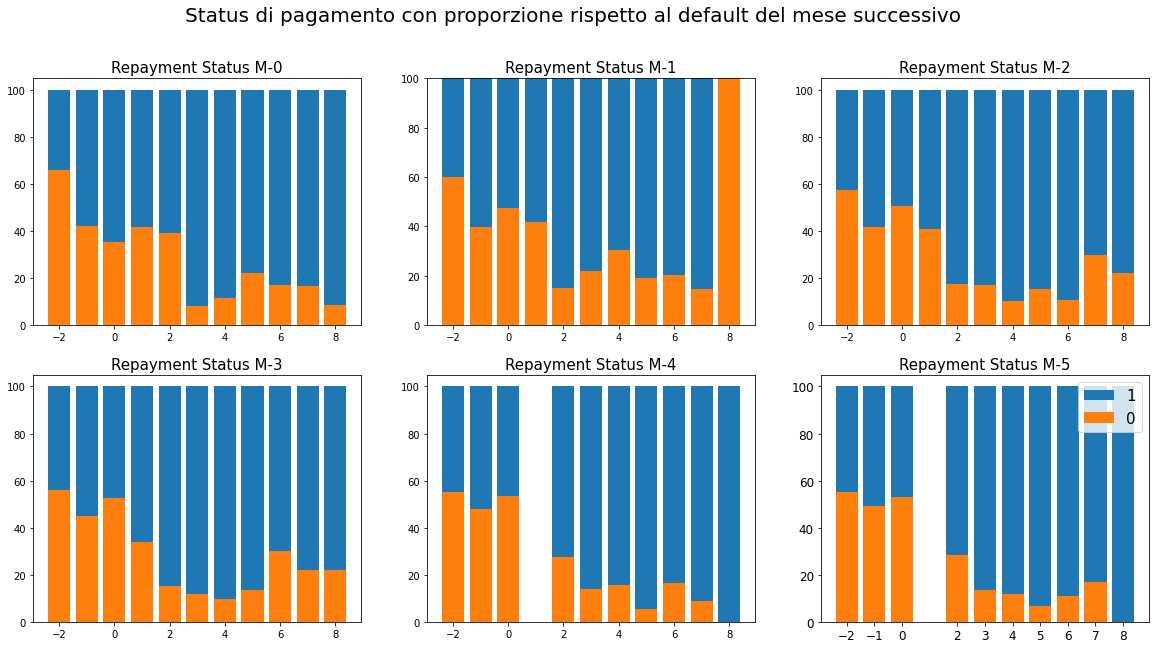

In [12]:
## Inserire link
plt.subplots(figsize=(20,10))

ind = sorted(dataset.PAY_1.unique())
pay_0 = (dataset.PAY_1[dataset['default pay'] == 0].value_counts(normalize=True))
pay_1 = (dataset.PAY_1[dataset['default pay'] == 1].value_counts(normalize=True))
total = pay_0.values+pay_1.values
pay_0_prop = np.true_divide(pay_0, total)*100
pay_1_prop = np.true_divide(pay_1, total)*100
plt.subplot(231)
plt.bar(ind, pay_1_prop, bottom=pay_0_prop, label='1')
plt.bar(ind, pay_0_prop, label='0')
plt.title("Repayment Status M-0", fontsize=15)

ind = sorted(dataset.PAY_2.unique())
pay_0 = (dataset.PAY_2[dataset['default pay'] == 0].value_counts(normalize=True))
pay_1 = (dataset.PAY_2[dataset['default pay'] == 1].value_counts(normalize=True))
for i in pay_0.index:
    if i not in pay_1.index:
        pay_1[i]=0
total = pay_0.values+pay_1.values
pay_0_prop = np.true_divide(pay_0, total)*100
pay_1_prop = np.true_divide(pay_1, total)*100
plt.subplot(232)
plt.bar(ind, pay_1_prop, bottom=pay_0_prop, label='1')
plt.bar(ind, pay_0_prop, label='0')
plt.title("Repayment Status M-1", fontsize=15)

ind = sorted(dataset.PAY_3.unique())
pay_0 = (dataset.PAY_3[dataset['default pay'] == 0].value_counts(normalize=True))
pay_1 = (dataset.PAY_3[dataset['default pay'] == 1].value_counts(normalize=True))
for i in pay_0.index:
    if i not in pay_1.index:
        pay_1[i]=0
total = pay_0.values+pay_1.values
pay_0_prop = np.true_divide(pay_0, total)*100
pay_1_prop = np.true_divide(pay_1, total)*100
plt.subplot(233)
plt.bar(ind, pay_1_prop, bottom=pay_0_prop, label='1')
plt.bar(ind, pay_0_prop, label='0')
plt.title("Repayment Status M-2", fontsize=15)

ind = sorted(dataset.PAY_4.unique())
pay_0 = (dataset.PAY_4[dataset['default pay'] == 0].value_counts(normalize=True))
pay_1 = (dataset.PAY_4[dataset['default pay'] == 1].value_counts(normalize=True))
for i in pay_0.index:
    if i not in pay_1.index:
        pay_1[i]=0
total = pay_0.values+pay_1.values
pay_0_prop = np.true_divide(pay_0, total)*100
pay_1_prop = np.true_divide(pay_1, total)*100
plt.subplot(234)
plt.bar(ind, pay_1_prop, bottom=pay_0_prop, label='1')
plt.bar(ind, pay_0_prop, label='0')
plt.title("Repayment Status M-3", fontsize=15)

ind = sorted(dataset.PAY_5.unique())
pay_0 = (dataset.PAY_5[dataset['default pay'] == 0].value_counts(normalize=True))
pay_1 = (dataset.PAY_5[dataset['default pay'] == 1].value_counts(normalize=True))
for i in pay_0.index:
    if i not in pay_1.index:
        pay_1[i]=0
for i in pay_1.index:
    if i not in pay_0.index:
        pay_0[i]=0
total = pay_0.values+pay_1.values
pay_0_prop = np.true_divide(pay_0, total)*100
pay_1_prop = np.true_divide(pay_1, total)*100
plt.subplot(235)
plt.bar(ind, pay_1_prop, bottom=pay_0_prop, label='1')
plt.bar(ind, pay_0_prop, label='0')
plt.title("Repayment Status M-4", fontsize=15)

ind = sorted(dataset.PAY_6.unique())
pay_0 = (dataset.PAY_6[dataset['default pay'] == 0].value_counts(normalize=True))
pay_1 = (dataset.PAY_6[dataset['default pay'] == 1].value_counts(normalize=True))
for i in pay_0.index:
    if i not in pay_1.index:
        pay_1[i]=0
for i in pay_1.index:
    if i not in pay_0.index:
        pay_0[i]=0
total = pay_0.values+pay_1.values
pay_0_prop = np.true_divide(pay_0, total)*100
pay_1_prop = np.true_divide(pay_1, total)*100
plt.subplot(236)
plt.bar(ind, pay_1_prop, bottom=pay_0_prop, label='1')
plt.bar(ind, pay_0_prop, label='0')
plt.title("Repayment Status M-5", fontsize=15)

plt.xticks(ind, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper right", fontsize=15)
plt.suptitle("Status di pagamento con proporzione rispetto al default del mese successivo", fontsize=20)

plt.show()

I grafici sopra mostrano la proporzione dei clienti che andranno in default il mese successivo rispetto allo status di un pagamento.
Dato un generico mese e il suo status, si evidenzia che più tardi un pagamento è completato più è probabile il deault.

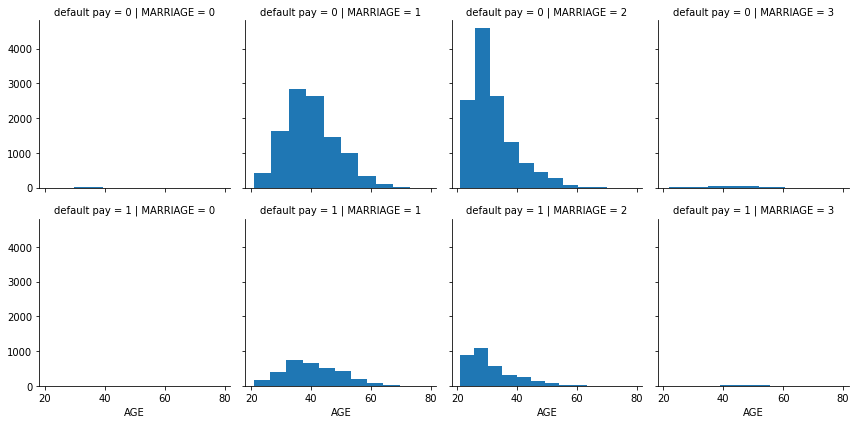

In [13]:
g = sns.FacetGrid(dataset, row='default pay', col='MARRIAGE')
g = g.map(plt.hist, 'AGE')
plt.show()

Dal grafico soprastante si può apprendere che le persone che sono andate in default con molta probabilità sono sposate nella fascia di età compresa tra 30 e 50 anni `[2, 2]` e non sposate nella fascia di età tra 20 e 30 `[2, 3]`.Possiamo concludere che la feature MARRIAGE può essere importante nel predirre il default.

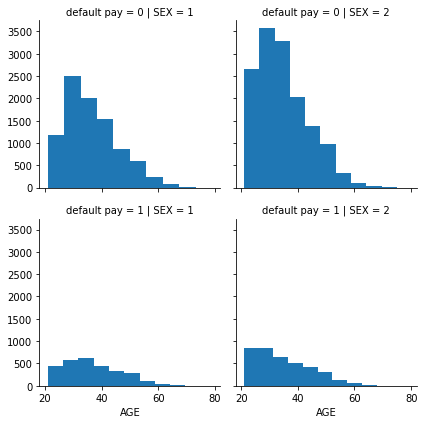

In [14]:
g = sns.FacetGrid(dataset, row='default pay', col='SEX')
g = g.map(plt.hist, 'AGE')

al grafico soprastante si può apprendere che le persone che sono andate in default con molta probabilità, paragonandole con persone di sesso maschile in tutte le fasce d'età, sono di sesso femminile nella fascia di età compresa tra 20 e 30 anni `[2, 2]`.
Possiamo concludere che la feature SEX può essere importante nel predirre il default.

## Correlazione tra features

Uso la correlazione di Pearson

In [15]:
cor = (dataset.iloc[:,1:].corr()).drop('default pay')

In [16]:
minCorrelation = 0.014
highCorrelation = [i
                   for i, correlation in enumerate(abs(cor['default pay'])) 
                   if correlation>minCorrelation]

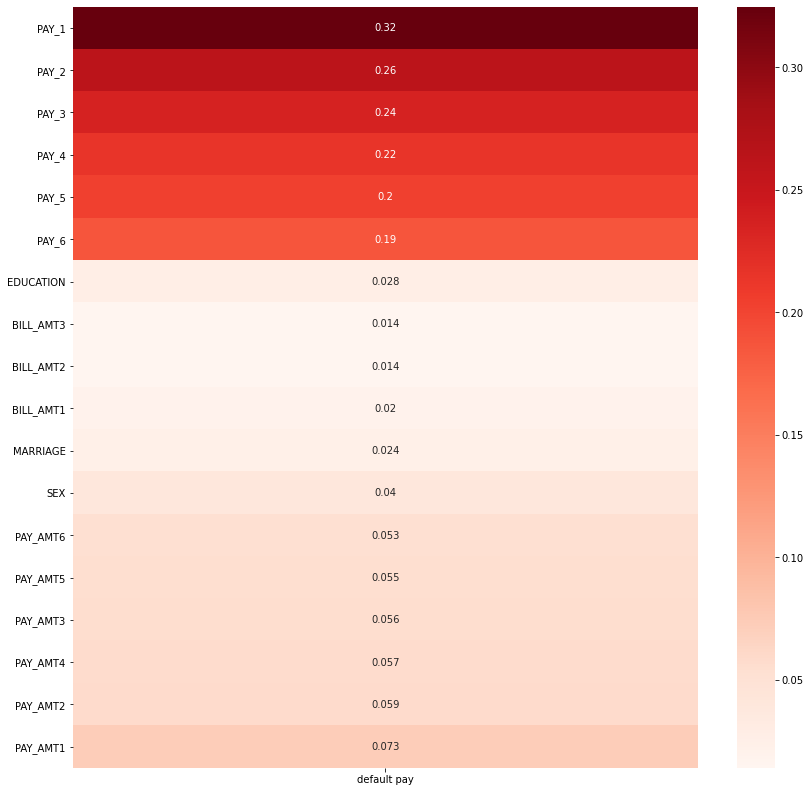

In [17]:
plt.figure(figsize=(14,14))
sns.heatmap(abs(cor [['default pay']].iloc[highCorrelation].sort_values(by='default pay', ascending=False)), annot=True, cmap=plt.cm.Reds)
plt.show()

## Data preprocessing

### One-Hot encoding

Eseguo pre-processing sulle variabili categoriche attraverso One-Hot-Encoding. Questo perchè non si tratta di valori ordinali, ma di semplici codifiche per rappresentare classi diverse.

In [18]:
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [19]:
dataset = pd.get_dummies(dataset, columns = categorical_cols)

Ottengo i dataset 

In [20]:
y = dataset['default pay']
x = dataset.drop(['default pay'], axis=1)
all_features = [str(index) for index in x.columns]

### Sbilanciamento classi

Dalle seguente cella si può verificare lo sbilanciamento delle classi. Si può risolvere la questione attraverso l'oversampling, l'undersampling oppure dando più peso agli errori sulla classe meno rappresentativa.

Percentuale della classe meno rappresentativa: 22.1%


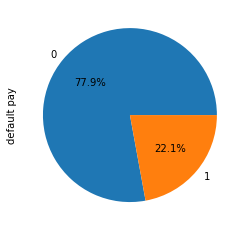

In [21]:
print(f'Percentuale della classe meno rappresentativa: {y[y == 1].shape[0] / y.shape[0]:.1%}')
dataset['default pay'].value_counts().plot.pie(autopct='%1.1f%%')

Per risolvere il problema ho deciso di adottare una tecnica di over sampling usando la libreria SMOTE.

In [22]:
#conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE

In [23]:
sm = SMOTE(random_state=42)
x, y = sm.fit_resample(x, y)
print(f'Verifico che le classi siano bilanciate: {y[y == 0].shape == y[y == 1].shape}')

Verifico che le classi siano bilanciate: True


### Data splitting and scaling

Divido il dataset nello sottoparti di training e validation set (30%).

In [24]:
X_train, X_val, y_train, y_val = train_test_split(
    x, y, test_size=0.3, random_state=randSeed)

In [25]:
X_train_relevant, X_val_relevant = X_train[:, highCorrelation], X_val[:, highCorrelation]

Applico la standardizzazione delle features.

In [26]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

X_train_relevant = sc.fit_transform(X_train_relevant)
X_val_relevant = sc.transform(X_val_relevant)

# Modelli

Definisco una funzione per il calcolo dell'intervallo di confidenza.

In [27]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

def different_model(score1, score2, X, level=0.95):
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    return diff_interval(score1, score2, N, N, Z)

In [28]:
from scipy.stats import norm

def conf_interval(model, X, y, level=0.95):
    score = f1_score(y, model.predict(X))
    N = len(X)
    Z = norm.ppf((1 + level) / 2)
    c = (2 * N * score + Z**2) / (2 * (N + Z**2))
    d = Z * np.sqrt(Z**2 + 4*N*score - 4*N*score**2) / (2 * (N + Z**2))
    return c - d, c + d

## Perceptron

In [29]:
from sklearn.linear_model import Perceptron
perceptron = Perceptron(random_state=randSeed)

In [30]:
perceptron.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

### Valutazione modello

In [31]:
models["Perceptron"] = {
    'conf_interval': conf_interval(perceptron, X_val, y_val, level=confidenceLevel),
    'f1-score': f1_score(y_val, perceptron.predict(X_val))
}
print(f'F1-score del modello: {models["Perceptron"]["f1-score"]:.2%}')
print(f'Intervallo di confidenza al {confidenceLevel:.1%} raggiunto dal modello: \
  {models["Perceptron"]["conf_interval"]}')

F1-score del modello: 83.86%
Intervallo di confidenza al 95.0% raggiunto dal modello:   (0.8323907730095819, 0.8445713562341648)


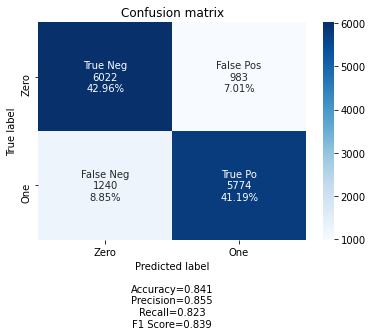

In [32]:
y_pred = perceptron.predict(X_val)
y_pred = (y_pred > 0.5)
conf_matr = confusion_matrix(y_val, y_pred)
labels = ['True Neg','False Pos','False Neg','True Po']
categories = ['Zero', 'One']
make_confusion_matrix(conf_matr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      title='Confusion matrix')

## Logistic regression

### Definizione modello

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

In [34]:
model = Pipeline([
    ('logRegr', LogisticRegression(solver='saga'))
])
grid = [{
    'logRegr__penalty': ['l2', 'l1'],
    'logRegr__C': np.logspace(-2, 2, 5),
},
{
    'logRegr__penalty': ['elasticnet'],
    'logRegr__C': np.logspace(-2, 2, 5),
    'logRegr__l1_ratio': [0.2, 0.5]
}]
gs_all = GridSearchCV(model, grid, cv=skf, n_jobs=-1)
gs_important_features = GridSearchCV(model, grid, cv=skf, n_jobs=-1)

### Solo features importanti

In [35]:
gs_important_features.fit(X_train_relevant, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [36]:
pd.DataFrame(gs_important_features.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logRegr__C,param_logRegr__penalty,param_logRegr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,1.484388,0.008879,0.002311,0.000095,1,elasticnet,0.2,"{'logRegr__C': 1.0, 'logRegr__l1_ratio': 0.2, ...",0.730166,0.732734,0.735669,0.732856,0.002248,1
17,1.492534,0.001864,0.002256,0.000050,10,elasticnet,0.5,"{'logRegr__C': 10.0, 'logRegr__l1_ratio': 0.5,...",0.730166,0.732826,0.735577,0.732856,0.002209,2
2,1.145743,0.005577,0.002238,0.000021,0.1,l2,NaN,"{'logRegr__C': 0.1, 'logRegr__penalty': 'l2'}",0.730258,0.732918,0.735394,0.732856,0.002097,2
4,1.149328,0.003335,0.002254,0.000066,1,l2,NaN,"{'logRegr__C': 1.0, 'logRegr__penalty': 'l2'}",0.730166,0.732918,0.735486,0.732856,0.002172,2
19,1.385795,0.140325,0.002077,0.000286,100,elasticnet,0.5,"{'logRegr__C': 100.0, 'logRegr__l1_ratio': 0.5...",0.730166,0.732734,0.735577,0.732826,0.002210,5


#### Valutazione modello

In [37]:
models["Logistic regression important features"] = {
    'conf_interval': conf_interval(gs_important_features, X_val_relevant, y_val, level=confidenceLevel),
    'f1-score': f1_score(y_val, gs_important_features.predict(X_val_relevant))
}
print(f'F1-score del modello: {models["Logistic regression important features"]["f1-score"]:.2%}')
print(f'Intervallo di confidenza al {confidenceLevel:.1%} raggiunto dal modello: \
  {models["Logistic regression important features"]["conf_interval"]}')

F1-score del modello: 66.78%
Intervallo di confidenza al 95.0% raggiunto dal modello:   (0.6599829478534277, 0.6755742566993698)


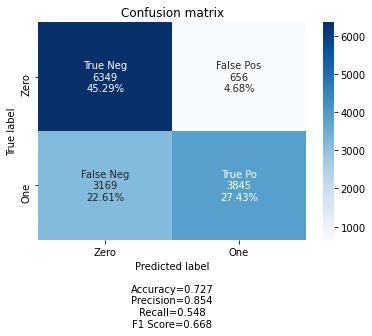

In [38]:
y_pred = gs_important_features.predict(X_val_relevant)
y_pred = (y_pred > 0.5)
conf_matr = confusion_matrix(y_val, y_pred)
labels = ['True Neg','False Pos','False Neg','True Po']
categories = ['Zero', 'One']
make_confusion_matrix(conf_matr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      title='Confusion matrix')

### Tutte le features

In [39]:
gs_all.fit(X_train, y_train);

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Applico una tecnica di Grid Search per ottimizare gli iperparametri. Poi alleno il miglior modello ottenuto

In [40]:
pd.DataFrame(gs_all.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logRegr__C,param_logRegr__penalty,param_logRegr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,4.266871,0.030248,0.003316,0.000104,10,l2,NaN,"{'logRegr__C': 10.0, 'logRegr__penalty': 'l2'}",0.876639,0.875722,0.874438,0.875600,0.000903,1
18,5.881339,0.029593,0.003387,0.000099,100,elasticnet,0.2,"{'logRegr__C': 100.0, 'logRegr__l1_ratio': 0.2...",0.876639,0.875631,0.874347,0.875539,0.000938,2
19,5.190942,1.018296,0.003013,0.000386,100,elasticnet,0.5,"{'logRegr__C': 100.0, 'logRegr__l1_ratio': 0.5...",0.876639,0.875631,0.874255,0.875508,0.000977,3
16,5.883450,0.038273,0.003294,0.000106,10,elasticnet,0.2,"{'logRegr__C': 10.0, 'logRegr__l1_ratio': 0.2,...",0.876639,0.875631,0.874255,0.875508,0.000977,3
7,5.710814,0.022872,0.006596,0.004630,10,l1,NaN,"{'logRegr__C': 10.0, 'logRegr__penalty': 'l1'}",0.876639,0.875631,0.874255,0.875508,0.000977,3


#### Valutazione modello

In [41]:
pd.Series(gs_all.best_estimator_['logRegr'].coef_[0], index=all_features).sort_values(ascending=False)

BILL_AMT3      0.105174
BILL_AMT2      0.100193
PAY_6_8        0.055801
BILL_AMT4      0.032761
PAY_5_6        0.028050
                 ...   
EDUCATION_1   -0.861241
EDUCATION_2   -0.906989
SEX_2         -0.912564
MARRIAGE_2    -0.931572
PAY_1_0       -1.062516
Length: 91, dtype: float64

In [42]:
models["Logistic regression all features"] = {
    'conf_interval': conf_interval(gs_all, X_val, y_val, level=confidenceLevel),
    'f1-score': f1_score(y_val, gs_all.predict(X_val))
}
print(f'F1-score del modello: {models["Logistic regression all features"]["f1-score"]:.2%}')
print(f'Intervallo di confidenza al {confidenceLevel:.1%} raggiunto dal modello: \
  {models["Logistic regression all features"]["conf_interval"]}')

F1-score del modello: 86.45%
Intervallo di confidenza al 95.0% raggiunto dal modello:   (0.8587529364230313, 0.8700835962282556)


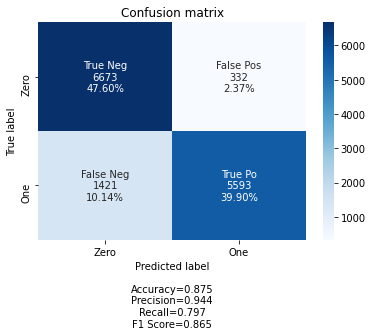

In [43]:
y_pred = gs_all.predict(X_val)
y_pred = (y_pred > 0.5)
conf_matr = confusion_matrix(y_val, y_pred)
labels = ['True Neg','False Pos','False Neg','True Po']
categories = ['Zero', 'One']
make_confusion_matrix(conf_matr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      title='Confusion matrix')

Come si evince, il modello di regressione logistica associa più importanza allo stato di pagamento dell'utimo mese.

### Valutazioni finali logistic regression
Il modello di regressione logistica supera il modello perceptron. In particolare, si nota che si raggiunge un'accuratezza maggiore se si usano tutte le features nel training del modello. Sono sicuro di questa accuratezza più elevata con una confidenza del 95%.

In [44]:
score_important_features = f1_score(y_val, gs_important_features.predict(X_val_relevant))
score_all = f1_score(y_val, gs_all.predict(X_val))
print(f"Secondo modello migliore del primo modello?: Si {different_model(score_important_features, score_all, X_val, level=0.95)}")

Secondo modello migliore del primo modello?: Si (0.18705603940881904, 0.20633105431802629)


## SVM

In [45]:
from thundersvm import SVC
svm = SVC()
grid = {
    'kernel': ['rbf'],
    'C': [0.01, 0.1, 1]
}
gs = GridSearchCV(svm, grid, cv=skf)
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, cache_size=None, class_weight=None, coef0=0.0,
                           decision_function_shape='ovo', degree=3,
                           gamma='auto', gpu_id=0, kernel='rbf', max_iter=-1,
                           max_mem_size=-1, n_jobs=-1, probability=False,
                           random_state=None, shrinking=False, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Valutazione modello

In [46]:
svm = gs.best_estimator_
models["SVM"] = {
    'conf_interval': conf_interval(svm, X_val, y_val, level=confidenceLevel),
    'f1-score': f1_score(y_val, svm.predict(X_val))
}
print(f'F1-score del modello: {models["SVM"]["f1-score"]:.2%}')
print(f'Intervallo di confidenza al {confidenceLevel:.1%} raggiunto dal modello: \
  {models["SVM"]["conf_interval"]}')

F1-score del modello: 86.24%
Intervallo di confidenza al 95.0% raggiunto dal modello:   (0.8566398399526858, 0.868043265861745)


## Decision tree

In [48]:
treeClassifier = tree.DecisionTreeClassifier(random_state=randSeed)
grid = {
    "max_depth": [5, 10, 15, 20, 25, 30, None],
    "min_samples_split": [2, 50, 100]
}
gs = GridSearchCV(treeClassifier, grid, cv=skf)
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
          

In [49]:
treeClassifier = gs.best_estimator_
print(f"Numero di foglie dell'albero: {treeClassifier.get_n_leaves()}")

Numero di foglie dell'albero: 257


### Visualizzazione modello

In [50]:
dot_data = tree.export_graphviz(treeClassifier, out_file=None, 
                                feature_names=all_features,  
                                class_names="Default",
                                filled=True)
graph = graphviz.Source(dot_data, format="png")

### Valutazione modello

In [51]:
models["Decision tree"] = {
    'conf_interval': conf_interval(treeClassifier, X_val, y_val, level=confidenceLevel),
    'f1-score': f1_score(y_val, treeClassifier.predict(X_val))
}
print(f'F1-score del modello: {models["Decision tree"]["f1-score"]:.2%}')
print(f'Intervallo di confidenza al {confidenceLevel:.1%} raggiunto dal modello: \
  {models["Decision tree"]["conf_interval"]}')

F1-score del modello: 83.62%
Intervallo di confidenza al 95.0% raggiunto dal modello:   (0.829962923808452, 0.8422158805949433)


## XGBoost

In [52]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### Valutazione modello

In [53]:
models["XGBoost"] = {
    'conf_interval': conf_interval(xgboost, X_val, y_val, level=confidenceLevel),
    'f1-score': f1_score(y_val, xgboost.predict(X_val))
}
print(f'F1-score del modello: {models["XGBoost"]["f1-score"]:.2%}')
print(f'Intervallo di confidenza al {confidenceLevel:.1%} raggiunto dal modello: \
  {models["XGBoost"]["conf_interval"]}')

F1-score del modello: 86.17%
Intervallo di confidenza al 95.0% raggiunto dal modello:   (0.8559308097784665, 0.8673584585360085)


## Artificial Neural Network

Per prima cosa verifichiamo che si dispone di una GPU per il training.

In [54]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Definizione modello

In [57]:
def build_nn():
  numberOfHiddenLayers = 5                    
  numberOfNeuronsForEachHL = [50, 40, 30, 20, 10]
  nn = Sequential()
  for i in range(numberOfHiddenLayers):
    if i == 0:
        nn.add(Dense(numberOfNeuronsForEachHL[i], input_dim=X_train.shape[1], kernel_initializer='uniform', activation='relu'))
    else:
        nn.add(Dense(numberOfNeuronsForEachHL[i], kernel_initializer=glorot_uniform(seed=0), activation='relu'))
  nn.add(Dense(1, kernel_initializer=glorot_uniform(seed=0), activation='sigmoid'))
  nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  nn.summary()
  return nn


mode_path = '../models/ann.h5'
callbacks = [ModelCheckpoint(filepath=mode_path, save_best_only=True)]

model = KerasClassifier(build_fn=build_nn, verbose=1, epochs=100, batch_size=256, 
                        validation_data=(X_val, y_val), callbacks=callbacks)

In [58]:
history = model.fit(X_train, y_train)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                4600      
_________________________________________________________________
dense_7 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_8 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_9 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 8,711
Trainable params: 8,711
Non-trainable params: 0
____________________________________________________

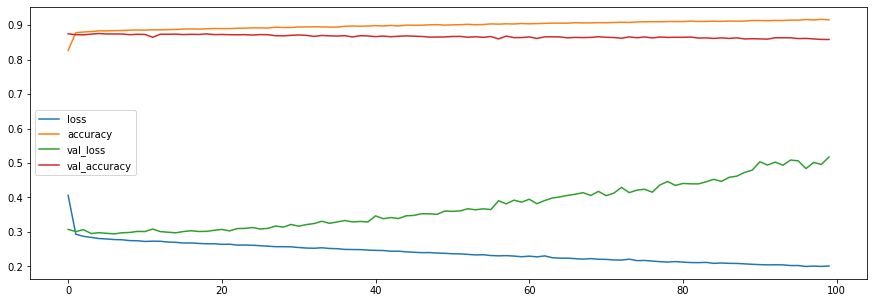

In [59]:
plt.figure(figsize=(15,5))
sns.lineplot(data=history.history, dashes=False)

### Valutazione modello

In [60]:
models["Artificial Neural Network"] = {
    'conf_interval': conf_interval(model, X_val, y_val, level=confidenceLevel),
    'f1-score': f1_score(y_val, model.predict(X_val))
}
print(f'F1-score del modello: {models["Artificial Neural Network"]["f1-score"]:.2%}')
print(f'Intervallo di confidenza al {confidenceLevel:.1%} raggiunto dal modello: \
  {models["Artificial Neural Network"]["conf_interval"]}')

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


55/55 [==============================] - 0s 1ms/step
F1-score del modello: 85.03%
Intervallo di confidenza al 95.0% raggiunto dal modello:   (0.8442654292488218, 0.8560782300744377)


55/55 [==============================] - 0s 2ms/step


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


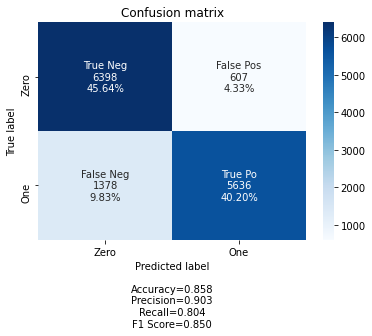

In [61]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5)
conf_matr = confusion_matrix(y_val, y_pred)
labels = ['True Neg','False Pos','False Neg','True Po']
categories = ['Zero', 'One']
make_confusion_matrix(conf_matr, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      title='Confusion matrix')

### Ottimizzazione modello (TPU richiesta)

Per prevenire il riavvio del runtime, a causa della selezione della TPU, non eseguire queste celle: andrebbero perse le metriche di confronto tra modelli. Se si vuole comunque procedere con l'esecuzione delle seguenti celle ricordarsi di cambiare runtime da `Runtime` -> `Cambia tipo di runtime` e selezionare `TPU` sotto la voce `Accelerazione hardware`.

#### Setup TPU

In [22]:
# Source: https://blog.tensorflow.org/2019/01/keras-on-tpus-in-colab.html

use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

tpu_address = TF_MASTER

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

#### Grid search e training modello


In [24]:
def create_model(dense_layer_sizes, optimizer='adam', dropout=0.1, init='uniform', dense_nparams=256):
    with strategy.scope():
      model = Sequential()
      model.add(Dense(dense_nparams, activation=tf.nn.relu, input_dim=X_train.shape[1], kernel_initializer=init,)) 
      model.add(Dropout(dropout), )
      for layer_size in dense_layer_sizes:
          model.add(Dense(layer_size, activation=tf.nn.relu))
          model.add(Dropout(dropout), )
      model.add(Dense(1, activation=tf.nn.softmax))
      model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1), 
                  loss=['binary_crossentropy'], 
                  metrics=['accuracy'])
    return model

In [36]:
small_param_grid = {
    'kc__epochs': [5],
    'kc__dense_nparams': [32, 256, 512],
    'kc__init': [ 'zeros'], 
    'kc__batch_size':[16],
    'kc__optimizer':['RMSprop', 'Adam', 'sgd'],
    'kc__dropout': [0.5, 0.4, 0.3, 0.2, 0.1, 0],
    'kc__dense_layer_sizes': [(50, 40, 30, 20, 10)]
}

param_grid = {
    'kc__epochs': [2, 3],
    'kc__dense_nparams': [32, 64, 128, 256, 512, 1024, 2048],
    'kc__init': [ 'uniform', 'zeros', 'normal'], 
    'kc__batch_size':[2, 16, 32, 64, 128, 256],
    'kc__optimizer':['RMSprop', 'Adam', 'Adamax', 'sgd'],
    'kc__dropout': [0.6, 0.7, 0.8, 0.9, 0.5, 0.4, 0.3, 0.2, 0.1, 0],
    'kc__dense_layer_sizes': [(32, 64, 128, 256, 512, 1024, 2048)],
}

mode_path = '../models/best_ann.h5'
callbacks = [ModelCheckpoint(filepath=mode_path, save_best_only=True)]

estimator = Pipeline([
                      ('kc', KerasClassifier(build_fn=create_model, verbose=1, 
                                             validation_data=(X_val, y_val), callbacks=callbacks))
                      ])

grid = GridSearchCV(estimator=estimator,  
                    n_jobs=-1, 
                    verbose=5,
                    return_train_score=True,
                    cv=5,
                    param_grid=param_grid)

In [ ]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   13.5s finished


In [ ]:
grid.best_params_

In [ ]:
score_best_ann = f1_score(y_val, y_pred.ravel())
print(f'F1-score della migliore ANN: {score_best_ann:.1%}')
print("Best score: %f using params %s" % (grid_result.best_score_, grid_result.best_params_))

## Valutazione finale modelli
Si paragonano gli intervalli di confidenza (al 95%) relativi agli F1-score di tutti i modelli provati nel notebook.
Il modello migliore si è rivelato essere una regressione logistica usando tutte le features a disposizione. Si evidenza come tutti i modelli del notebook abbiano differenza statisticamente significativa rispetto ad un modello random.

In [62]:
random = DummyClassifier(strategy="uniform", random_state=42)
random.fit(X_train, y_train)

models["Dummy classifier"] = {
    'conf_interval': conf_interval(random, X_val, y_val, level=confidenceLevel),
    'f1-score': f1_score(y_val, random.predict(X_val))
}
print(f'F1-score del modello: {models["Dummy classifier"]["f1-score"]:.2%}')
print(f'Intervallo di confidenza al {confidenceLevel:.1%} raggiunto dal modello: \
  {models["Dummy classifier"]["conf_interval"]}')

F1-score del modello: 50.16%
Intervallo di confidenza al 95.0% raggiunto dal modello:   (0.49332758401437193, 0.5098787214924633)


In [63]:
print(f"{'Modello':<40}{'Intervallo di confidenza F1-score':<15}")
for k in models.keys():
  print(f'{k:<40}{str(models[k]["conf_interval"]):<15}')

Modello                                 Intervallo di confidenza F1-score
Perceptron                              (0.8323907730095819, 0.8445713562341648)
Logistic regression important features  (0.6599829478534277, 0.6755742566993698)
Logistic regression all features        (0.8587529364230313, 0.8700835962282556)
SVM                                     (0.8566398399526858, 0.868043265861745)
Decision tree                           (0.829962923808452, 0.8422158805949433)
XGBoost                                 (0.8559308097784665, 0.8673584585360085)
Artificial Neural Network               (0.8442654292488218, 0.8560782300744377)
Dummy classifier                        (0.49332758401437193, 0.5098787214924633)


In [64]:
print(f"{'Dummy classifier vs modello':<45}{'Significativamente diverso?':<35}")
for k in models.keys():
  print(f'Dummy Classifier vs {k:<45}{str(different_model(\
      models[k]["f1-score"], models["Dummy classifier"]["f1-score"], X_val, level=0.95)):<35}')

Dummy classifier vs modello                  Significativamente diverso?        
Dummy Classifier vs Perceptron                                   (0.32669418168314796, 0.3472462633000783)
Dummy Classifier vs Logistic regression important features       (0.15485038345475338, 0.1775915857312121)
Dummy Classifier vs Logistic regression all features             (0.3528846467368758, 0.372944416175935)
Dummy Classifier vs SVM                                          (0.35078675735732495, 0.370887740604773)
Dummy Classifier vs Decision tree                                (0.3242803641040246, 0.3448754453215812)
Dummy Classifier vs XGBoost                                      (0.3500827680319159, 0.3701975104936143)
Dummy Classifier vs Artificial Neural Network                    (0.3384961174759701, 0.3588322645476768)
Dummy Classifier vs Dummy classifier                             (-0.011705024895070297, 0.011705024895070297)
